
# 🏎️ Formula 1 Race Outcome Predictor

This notebook is part of the **F1 Race Outcome Predictor** project, which uses the [FastF1 API](https://theoehrly.github.io/Fast-F1/) and machine learning to analyze and predict Formula 1 race results.

### 📌 Objectives of this notebook:
- Load and explore race and qualifying data from the 2024 and 2025 F1 seasons
- Investigate which variables show meaningful relationships with race outcomes
- Visualize trends in driver performance, team competitiveness, and race dynamics
- Analyze multicollinearity among the influential variables. (Occam's Razor principle)
- Identify and validate features that are likely to improve the predictive performance of our machine learning model
- Clean and structure the data for future use in modeling pipelines and experiments

### 📊 Data Sources:
- [FastF1](https://theoehrly.github.io/Fast-F1/): provides timing, telemetry, and session result data via a Python API

> This notebook is intended for data exploration and insight discovery. Reusable logic (data loading, feature engineering, etc.) will be modularized into `.py` files inside the `src/` directory.

---

📁 **Project Root**: [f1-race-outcome-predictor](https://github.com/Rovsi135/F1-race-outcome-predictor)  
🧠 Authors: *Rovshan Ayyubov, Lucas van Zuijdam*  
📅 Start Date: *26/03/2025*

---

### Libraries:

In [30]:
import fastf1 as f1
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Suppress log messages from output
import logging
logging.getLogger("fastf1").setLevel(logging.WARNING)

### 🎯 EDA:


---

###  Fetch:
We fetch our data from fastF1 API to a local table to be able to manipulate it easily. The following code give us the data for all races occured in 2024:

In [31]:
#Use a list to store the dataframes that has been generated through the loop
#to concatenate them after the loop. 
list_qualifying_dataframes = []
for i in range(1, 25): #Iterate over (24) weekends
    #Load race session
    session = f1.get_session(2024, i, "Race")
    session.load(telemetry=False, laps=False, weather=False, messages=False)

    #Transfer information to a dataframe
    df_Race = session.results[["TeamName", "Abbreviation", "Position", "GridPosition", "Status"]].copy()
    df_Race["Round"] = i
    df_Race.rename(columns={"GridPosition": "QPosition"}, inplace=True)

    #Store the dataframe in a list to concatenate after
    list_qualifying_dataframes.append(df_Race)

df_2024_all_races = pd.concat(list_qualifying_dataframes, ignore_index=True, axis=0)
df_2024_all_races


,TeamName,Abbreviation,Position,QPosition,Status,Round
0,Red Bull Racing,VER,1.0,1.0,Finished,1
1,Red Bull Racing,PER,2.0,5.0,Finished,1
2,Ferrari,SAI,3.0,4.0,Finished,1
3,Ferrari,LEC,4.0,2.0,Finished,1
4,Mercedes,RUS,5.0,3.0,Finished,1
...,...,...,...,...,...,...
474,Haas F1 Team,MAG,16.0,14.0,Lapped,24
475,RB,LAW,17.0,12.0,Retired,24
476,Kick Sauber,BOT,18.0,9.0,Retired,24
477,Williams,COL,19.0,20.0,Retired,24


🤔 **Status column — what do we do with “Retired”?**

While inspecting the dataset, we can see that some entries have `status = "Retired"` (and likely other non-finish statuses as well).  

Before making any decisions about what we do with such entries, it’s useful to see **what possible values the `status` column can take**:

In [32]:
#Find the distinct states of "Status"
distinct_status = df_2024_all_races["Status"].unique()
print("Distinct Status values in 2024 Races:")
for status in distinct_status:
    print(status)

Distinct Status values in 2024 Races:
Finished
Lapped
Retired
Did not start
Disqualified


### 🧹Cleaning Data:
Including non-finish statuses would mix together very different phenomena:

- **`Retired` / `Did not start` / `Disqualified`**  
  These outcomes are often caused by accidents, technical failures, rule violations, or other random events. They say more about **reliability, luck, or penalties** than about underlying race pace.  
  If we kept them, the model would be punished for not predicting **rare, chaotic events** that we don’t have good features for (e.g. engine failure or a crash).

- **`Finished` and `Lapped`**  
  These drivers are still **classified finishers**, so they have a meaningful finishing position we can try to predict.

To keep the problem well-defined and reduce noise, we make the following decision:

- **Keep only rows where `Status` is `Finished` or `Lapped`.**  
- **Drop rows with `Status` = `Retired`, `Did not start`, or `Disqualified`.**

This means our regression target “finishing position” refers to **drivers who completed the race**, and we postpone modeling DNFs/DSQs as a separate, more advanced task in the future.

In [33]:
df_2024_all_races_wo_dnf = df_2024_all_races[df_2024_all_races["Status"].isin(["Finished", "Lapped"])]
distinct_status_wo_dnf = df_2024_all_races_wo_dnf["Status"].unique()
for status in distinct_status_wo_dnf:
    print(status)

Finished
Lapped


### 🔎 Feature Selection: What Impacts Race Results?

Now we will start identifying which data is useful for training our machine learning model.  
Let's First look at how **qualifying position** affects race results:

### Qualifying Position ###

We begin with analyzing **qualifying position** to see how much it affects final race performance. We will analyze the **$R^2$** value between the qualifying and race results of all the races in 2024. But first let's generate a visual to better understand the correlation between the *grid position* and *race results*:

Text(0.5, 1.0, 'Qualifying vs Race Results - All Races 2024')

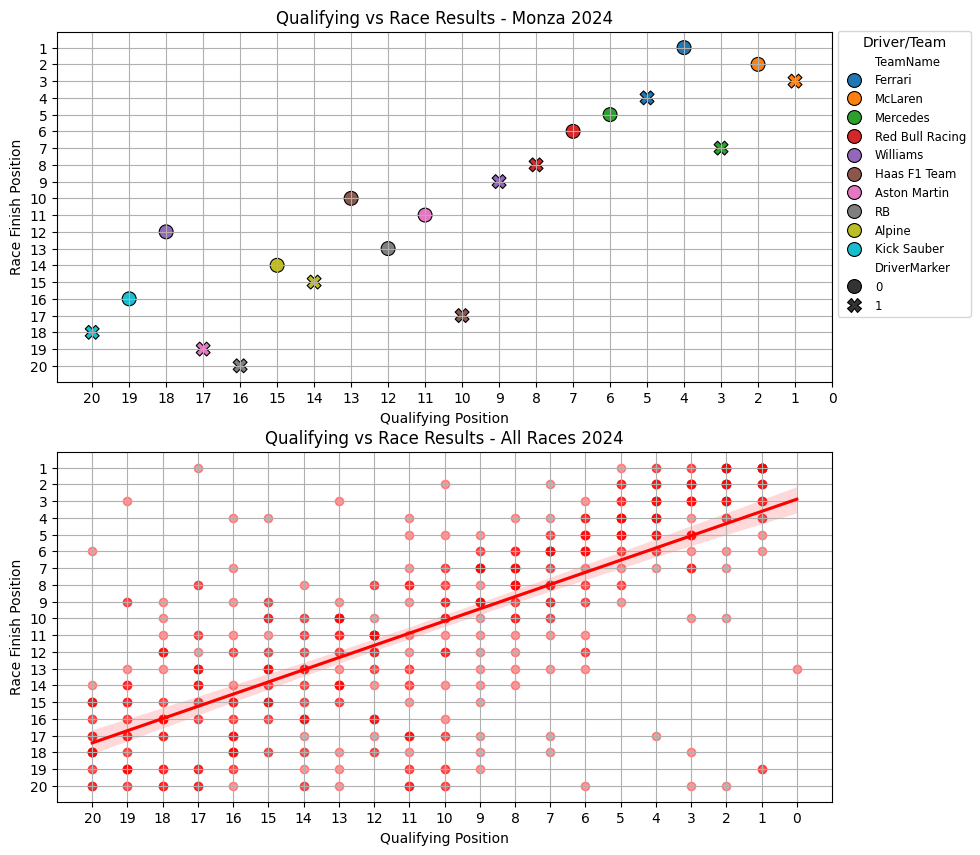

In [34]:
#To assign different marker for different drivers for each team
df_2024_all_races['DriverMarker'] = df_2024_all_races.groupby('TeamName').cumcount() % 2

#For 1 unit length grid line:
x_min, x_max = int(df_2024_all_races['QPosition'].min()), int(df_2024_all_races['QPosition'].max())
y_min, y_max = int(df_2024_all_races['Position'].min()), int(df_2024_all_races['Position'].max())

df_2024_monza = df_2024_all_races[df_2024_all_races["Round"] == 16]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

sns.scatterplot(
    data = df_2024_monza,
    x="QPosition",
    y="Position",
    hue="TeamName",          
    style="DriverMarker", 
    s=100,                   
    edgecolor="black",      
    ax = ax[0]
)

sns.regplot(
    data=df_2024_all_races,
    x="QPosition",
    y="Position",
    color="red",
    #Add transparency to each data, so that when they get stacked they appear more dense
    scatter_kws={"alpha": 0.4},
    ax = ax[1]
)

for i in range(0,2):
    #Invert axises since negative correlation between best place and position 
    #e.x. 1st is the best position but smallest in terms of integer
    ax[i].invert_xaxis();
    ax[i].invert_yaxis();

    # Char ; at the end of each line suppresses the output of that column
    ax[i].set_xlabel("Qualifying Position");
    ax[i].set_ylabel("Race Finish Position");
    ax[i].grid(True);
    ax[0].legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize='small', title="Driver/Team");
    ax[i].set_xticks(range(x_min, x_max + 1));
    ax[i].set_yticks(range(y_min, y_max + 1));

ax[0].set_title("Qualifying vs Race Results - Monza 2024");
ax[1].set_title("Qualifying vs Race Results - All Races 2024")


### 📊 Relationship Between Qualifying and Race Results

The visualizations above explore how a driver's qualifying position correlates with their final result of that race during the 2024 Formula 1 season.

- **Top Plot – Monza 2024 Only:**  
  This scatter plot shows each driver's qualifying and finishing position in the Monza GP in 2024. Teams are color-coded, and each driver within the same team have a unique marker. This gives a glimpse of a possible relationship between qualifying and race results in a single race. <br>
  *However, one event isn’t enough to confirm any strong pattern since the sample size is too small.*


- **Bottom Plot – All Races 2024:**  
  This regression plot combines data from all races in the 2024 season provide a more comprehensive view. Each point represents a driver's qualifying and finishing position in a given race. A regression line is fitted to the data, giving a sense of the overall trend: **better qualifying positions generally lead to better race results**.

These plots give us a starting point for building a predictive model, suggesting that where a driver qualifies probably influences where they finish.


### 📈 Regression Model and $R^2$ Value

Now we proceed by training a simple regression model to evaluate the relationship between qualifying results and race outcomes.  
By calculating the coefficient of determination ($R^2$), we can measure how well qualifying position explains the variation in final race position across the 2024 season.

A higher $R^2$ value indicates a stronger predictive relationship, while a lower value suggests that qualifying alone may not be sufficient to predict race results accurately.

First we will be dividing our dataset into training and test sets:

In [35]:
df_all_races_train, df_all_races_test = train_test_split(
    df_2024_all_races, test_size=0.2, random_state=7
)

X_qualifying_req_train = df_all_races_train[["QPosition"]].copy()
y_qualifying_req_train = df_all_races_train[["Position"]].copy()

X_qualifying_req_test = df_all_races_test[["QPosition"]].copy()
y_qualifying_req_test = df_all_races_test[["Position"]].copy()

Then we can fit our linear regerssion model and produce $R^2$ value:

In [36]:

req_qualifying = LinearRegression()
req_qualifying.fit(X_qualifying_req_train, y_qualifying_req_train)
req_qualifying.score(X_qualifying_req_train, y_qualifying_req_train)


0.5389281656213463

Lets clean up the data with extracting the occurences of did not finish (DNF) and recalculate the $R^2$ again:

In [37]:
df_all_races_wo_dnf_train, df_all_races_wo_dnf_test = train_test_split(
    df_2024_all_races_wo_dnf, test_size=0.2, random_state=0
)

X_qualifying_req_train_filtered = df_all_races_wo_dnf_train[["QPosition"]].copy()
y_qualifying_req_train_filtered = df_all_races_wo_dnf_train[["Position"]].copy()

X_qualifying_req_test_filtered = df_all_races_wo_dnf_test[["QPosition"]].copy()
y_qualifying_req_test_filtered = df_all_races_wo_dnf_test[["Position"]].copy()


req_qualifying_filtered = LinearRegression()
req_qualifying_filtered.fit(X_qualifying_req_train_filtered, y_qualifying_req_train_filtered)
#output R^2 for train and test sets
req_qualifying_filtered.score(X_qualifying_req_train_filtered, y_qualifying_req_train_filtered), req_qualifying_filtered.score(X_qualifying_req_test_filtered, y_qualifying_req_test_filtered)


(0.6209582392096755, 0.7114363961832676)

### 📈 Effect of Removing DNFs on the Quali–Race Relationship

Earlier, we fitted a simple linear regression model to quantify how well **qualifying position** explains **race finishing position**:

- **Before filtering DNFs / non-finishers**:  
  The model achieved an \(R^2\) of about ~0.54 on the training data, meaning quali position explained a bit more than half of the variance in race results.

- **After removing DNFs / DSQs / DNS and keeping only classified finishers** (`Finished` and `Lapped`):  
  The \(R^2\) increased noticeably (to around ~0.62 on train and ~0.71 on test), showing that once we remove random/non-finish events, the linear relationship between qualifying and final position becomes much clearer.

This confirms our intuition: **where you start on the grid is strongly related to where you finish**, especially when we ignore races where something “weird” happens (crashes, mechanical failures, penalties, etc.).

---

### 🔗 Moving Beyond One Feature: Correlation Matrix

So far, we’ve only looked at **one relationship**: `QPosition` -> `Position`.  
However, our dataset contains many other variables (year, circuit(round), team, etc.), and we’d like to know:

- Which features are **most strongly related** to the finishing position?
- Which features are **strongly related to each other** (potentially redundant)?

To get a quick overview of how all numeric variables relate to one another, we now compute a **correlation matrix**. This gives us:

- The correlation between each feature and the target (`Position`)  
- The correlation between pairs of features (e.g. `QPosition` vs `GridPosition`, or other numeric fields) 

Features that are **highly correlated with the target** are likely to be useful predictors.  
Pairs of features that are **highly correlated with each other** may indicate redundancy or *multicollinearity*. In those cases, we only need to keep one of them in our model to keep things simple and avoid duplicating the same information.

In the next step, we’ll compute and visualize this correlation matrix to better understand the structure of our data:

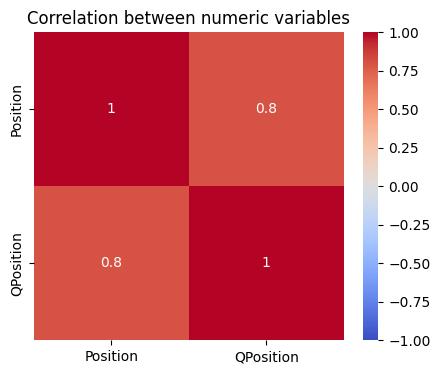

In [38]:
#Fix this later for bigger dataset
corr_cols = ["Position", "QPosition"]
corr_cols = [c for c in corr_cols if c in df_2024_all_races_wo_dnf.columns]  # keep only those that exist

corr = df_2024_all_races_wo_dnf[corr_cols].corr()


plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between numeric variables")
plt.show()

### 🧩 One-Hot Encoding (Dummy Features) for Teams and Drivers

So far we have a mix of:

- **Numeric features**, like:
  - `GridPosition` – starting position on the grid  
  - `RoundNumber` – which round of the season the race is  

- **Categorical features**, like:
  - `TeamName` – the constructor (Ferrari, McLaren, Red Bull, …)  
  - `Abbreviation` – the driver (VER, HAM, NOR, …)  

Linear regression can only work with **numeric** inputs, so we need to convert these categorical columns into numbers.  
However, we don’t want to assign arbitrary rankings like `Ferrari = 1`, `McLaren = 2`, `RedBull = 3`, because that would create a fake ordering and distances that don’t exist.

Instead, we use **one-hot encoding** (dummy variables):

- For each team and each driver, we create a binary feature:
  - `TeamName_McLaren = 1` if the row is McLaren, else 0  
  - `TeamName_Red Bull = 1` if the row is Red Bull, else 0  
  - `Abbreviation_VER = 1` if the driver is VER, else 0  
  - `Abbreviation_HAM = 1` if the driver is HAM, else 0  
  - etc.
- We use `drop_first=True`, so one team and one driver become the **baseline** (all zeros) to avoid perfect collinearity.

After one-hot encoding, a linear regression model conceptually looks like:

$$[
\hat{y} = \beta_0 
+ \beta_1 \cdot \text{GridPosition}
+ \beta_2 \cdot \text{RoundNumber}
+ \sum_{k} \gamma_k \cdot \text{TeamName}_k
+ \sum_{j} \delta_j \cdot \text{Abbreviation}_j
]$$

Example interpretation:

- If `TeamName_Red Bull = 1` and its coefficient \(\gamma_{\text{RedBull}}\) is negative, then being in Red Bull tends to improve (lower) the predicted finishing position compared to the baseline team.
- If `Abbreviation_VER = 1` and its coefficient \(\delta_{\text{VER}}\) is negative, then Verstappen tends to finish better than the baseline driver, given the same grid position, round, and team.

Each dummy feature simply answers: *“Is this row from this team/driver? (yes=1 / no=0)”*, and the linear regression model learns from the data how much that yes/no shifts the expected finishing position.

In the next step, we create these dummy variables using `pd.get_dummies` for both `TeamName` and `Abbreviation` and prepare the data for our linear regression model.


In [ ]:
feature_cols = ["QPosition", "Round", "TeamName", "Abbreviation"]
target_col = "Position"

X = df_2024_all_races_wo_dnf[feature_cols].copy()
y = df_2024_all_races_wo_dnf[target_col].copy()

X_encoded = pd.get_dummies(X, columns=["TeamName", "Abbreviation"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

X_encoded.head()

,QPosition,TeamName_Aston Martin,TeamName_Ferrari,TeamName_Haas F1 Team,TeamName_Kick Sauber,TeamName_McLaren,TeamName_Mercedes,TeamName_RB,TeamName_Red Bull Racing,TeamName_Williams,...,Abbreviation_PER,Abbreviation_PIA,Abbreviation_RIC,Abbreviation_RUS,Abbreviation_SAI,Abbreviation_SAR,Abbreviation_STR,Abbreviation_TSU,Abbreviation_VER,Abbreviation_ZHO
0,1.0,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,5.0,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
2,4.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3.0,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False


### Let's finally train our first model:

In [44]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

And now lets validate and see how well our model has done

In [45]:
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print("Train  - MAE: {:.3f}, MSE: {:.3f}, R²: {:.3f}".format(mae_train, mse_train, r2_train))
    print("Test   - MAE: {:.3f}, MSE: {:.3f}, R²: {:.3f}".format(mae_test, mse_test, r2_test))

evaluate_regression(linreg, X_train, y_train, X_test, y_test)

Train  - MAE: 1.938, MSE: 6.895, R²: 0.745
Test   - MAE: 1.897, MSE: 6.575, R²: 0.769


### 📏 Interpreting the Linear Regression Metrics

For the linear regression model with features (`GridPosition`, `RoundNumber`, `TeamName`, `Abbreviation`), we obtained:

- **Train** – MAE: ~1.94, MSE: ~6.89, R²: ~0.75  
- **Test**  – MAE: ~1.90, MSE: ~6.57, R²: ~0.77  

Here is what each metric means:

- **MAE (Mean Absolute Error)**  
  $$[
  \text{MAE} = \frac{1}{N} \sum_i |y_i - \hat{y}_i|
  ]$$
  This measures the **average absolute difference** between the true finishing position and the predicted one.  
  → An MAE of ~1.9 means that, on average, the model is off by **about 2 positions** (e.g. predicting P5 instead of P3 or P7).

- **MSE (Mean Squared Error)**  
  $$[
  \text{MSE} = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2
  ]$$  
  This is similar to MAE but **squares the errors**, so larger mistakes are penalized more strongly.  
  → The exact value is less intuitive than MAE, but it’s useful for comparing models: **lower MSE is better**.

- **R² (Coefficient of Determination)**  
  $$[
  R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
  ]$$  
  This measures how much of the **variance in the target** (finishing position) is explained by the model compared to a simple baseline that always predicts the mean.  
  - \(R^2 = 0\): model is no better than predicting the average position every time  
  - \(R^2 = 1\): perfect predictions  

  Our R² values of ~0.75 (train) and ~0.77 (test) mean the model explains **around 75% of the variability** in finishing positions on this dataset, which is quite strong for F1 results (a noisy, chaotic problem).

Finally, the fact that **train and test metrics are very similar** (MAE and R² almost the same) suggests:

- The model is **not overfitting** (it generalizes reasonably well to unseen races).
- The chosen features (grid position + round + team + driver) capture a large part of the predictable structure in the data.
